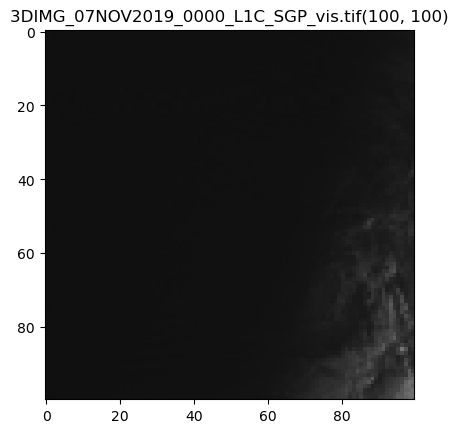

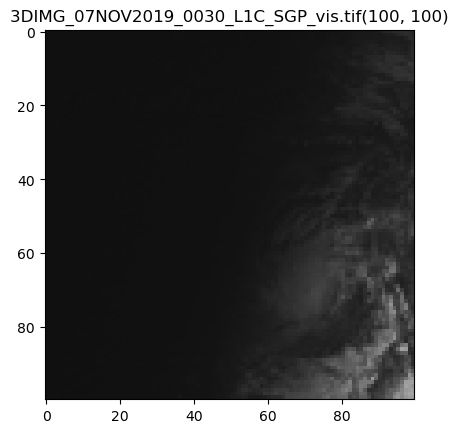

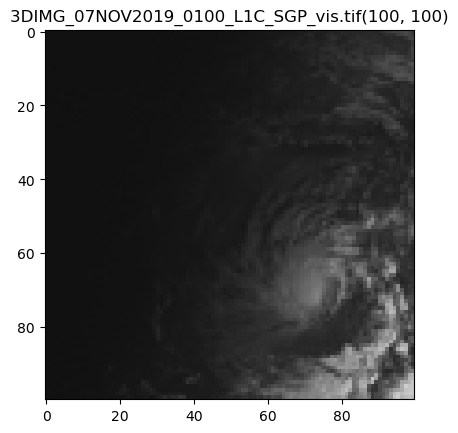

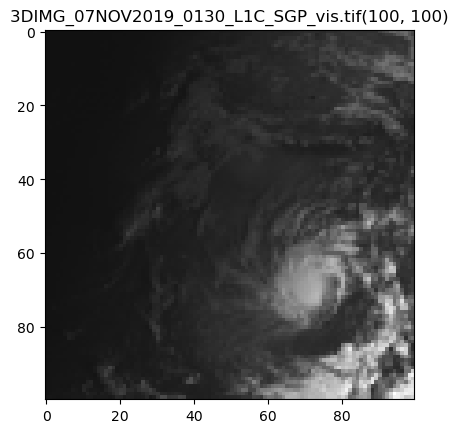

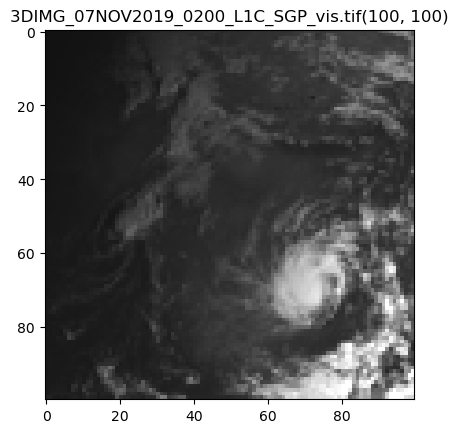

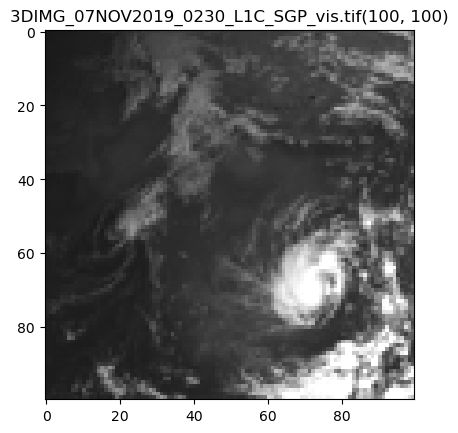

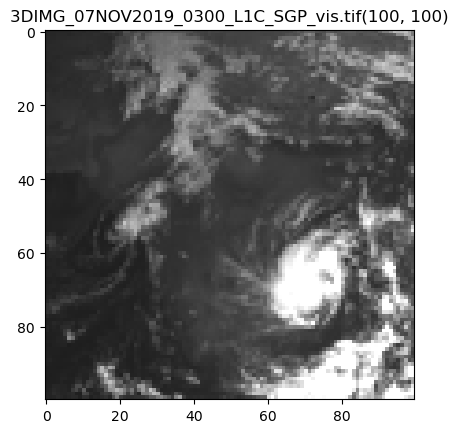

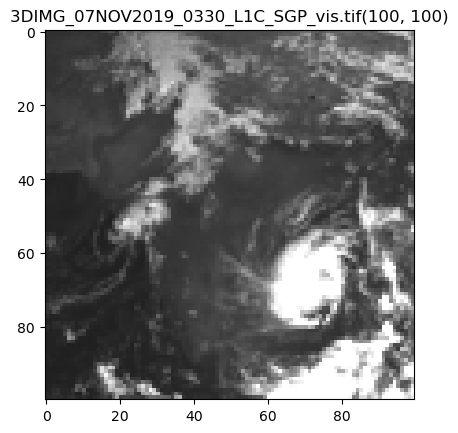

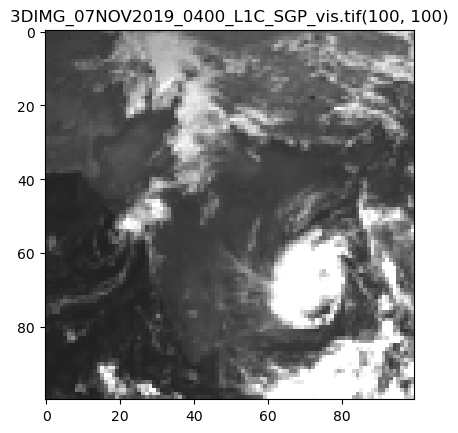

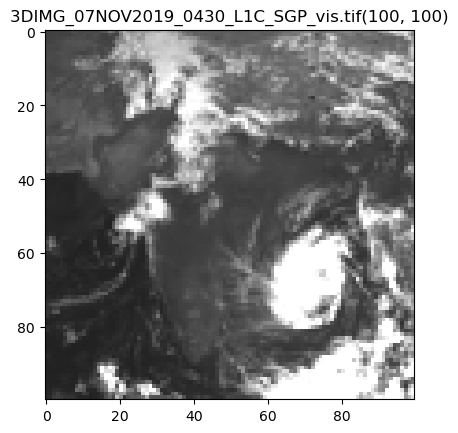

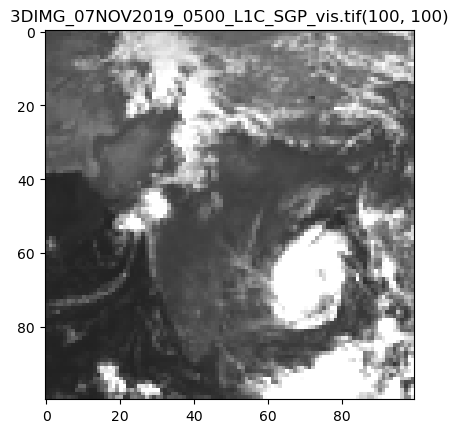

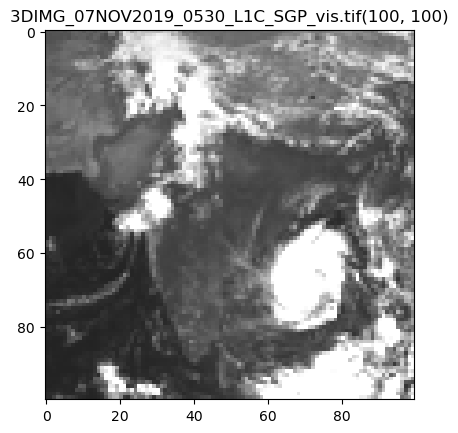

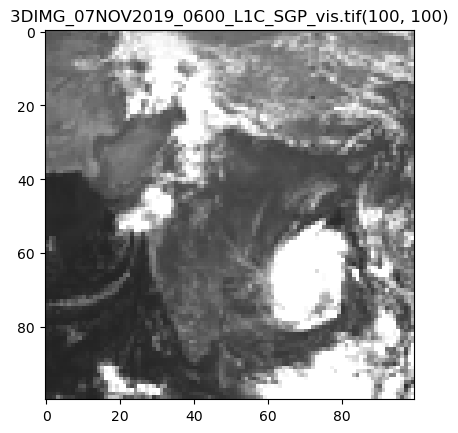

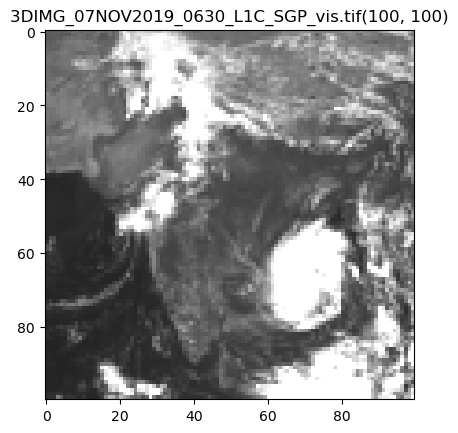

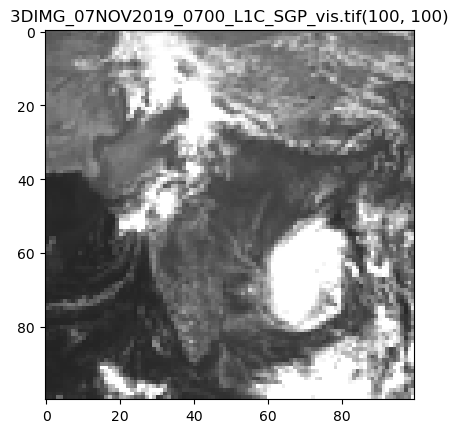

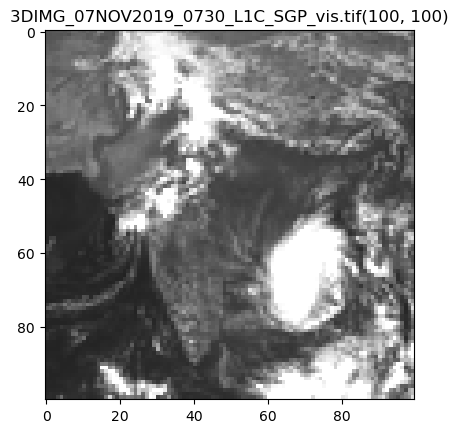

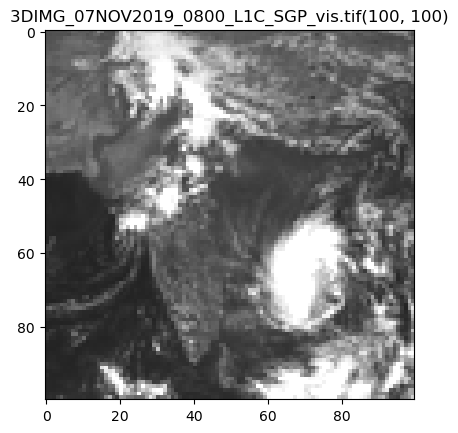

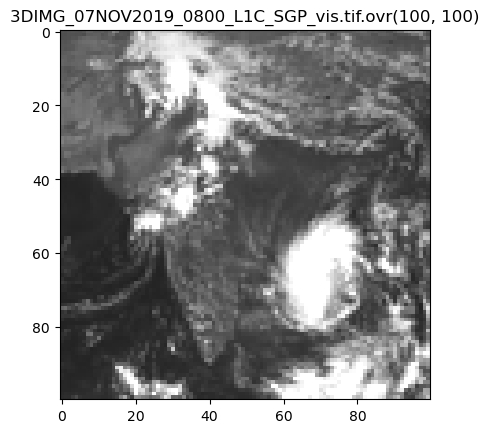

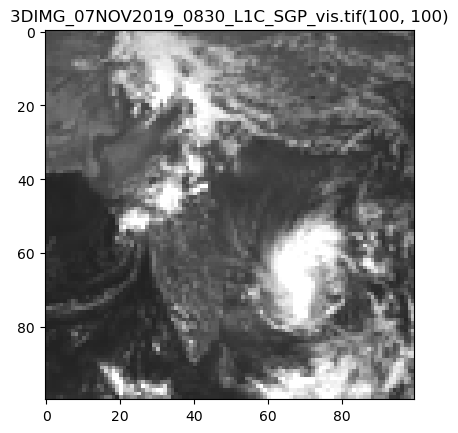

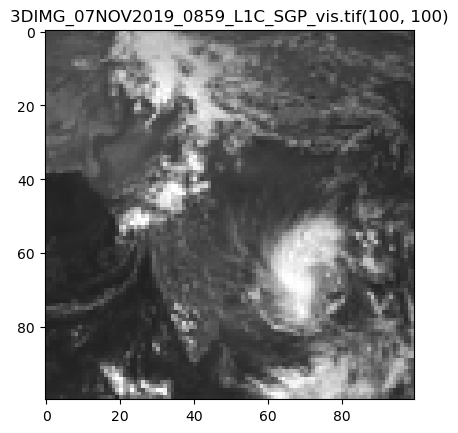

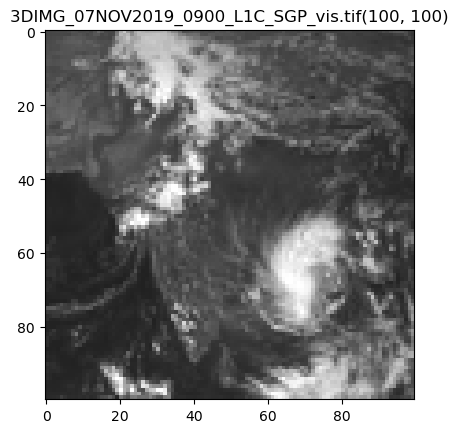

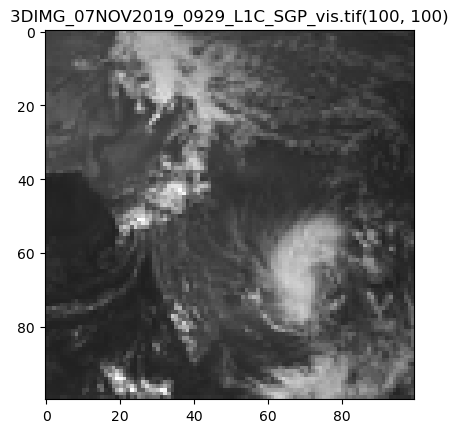

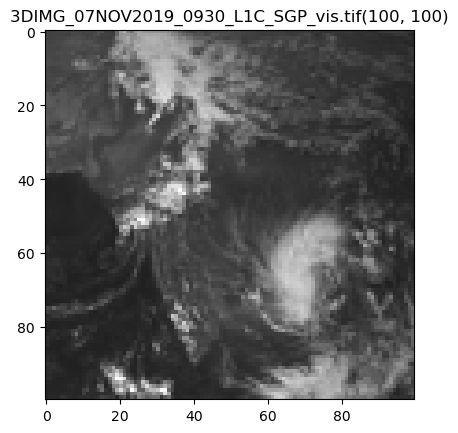

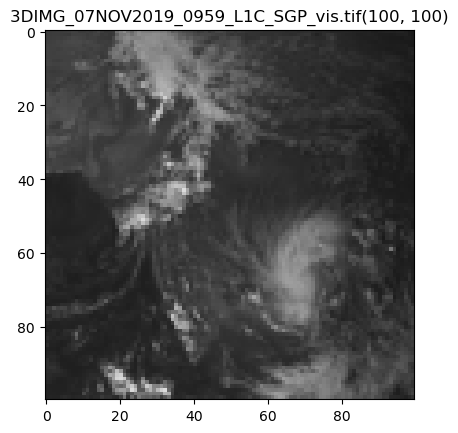

(24, 100, 100)
(14, 10, 100, 100)
(14, 10, 100, 100)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 100, 100,    59200     
                             40)                                 
                                                                 
 dropout (Dropout)           (None, None, 100, 100,    0         
                             40)                                 
                                                                 
 batch_normalization (Batch  (None, None, 100, 100,    160       
 Normalization)              40)                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 100, 100,    115360    
                             40)                                 
                                                                 
 dr

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 21s 3s/step - loss: 1.6292 - val_loss: 0.6931
Epoch 3/32
2/2 [==============================] - 23s 3s/step - loss: 1.6201 - val_loss: 0.6931
Epoch 4/32
2/2 [==============================] - 21s 3s/step - loss: 1.6334 - val_loss: 0.6931


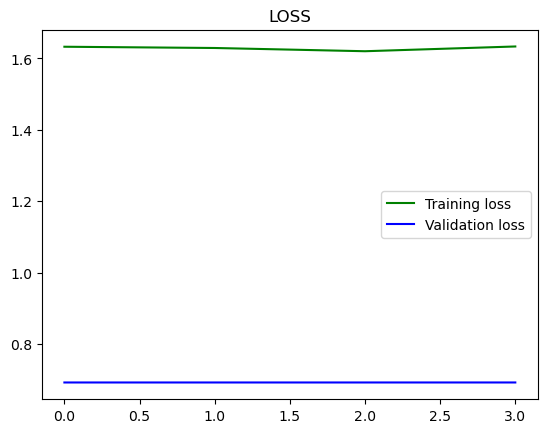

1/1 [==============================] - 1s 1s/step


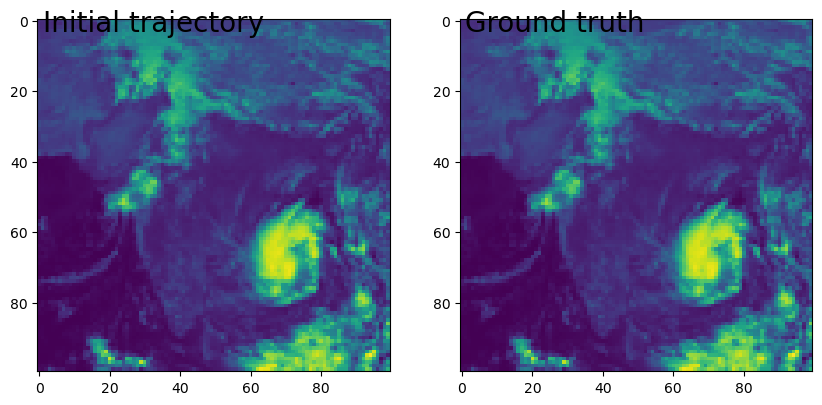

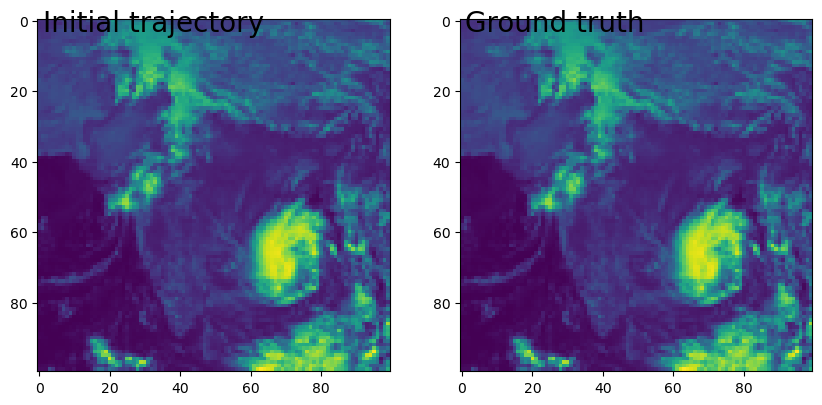

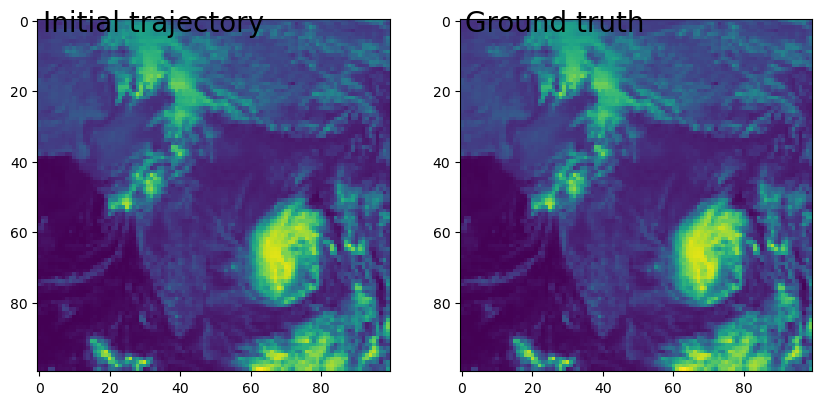

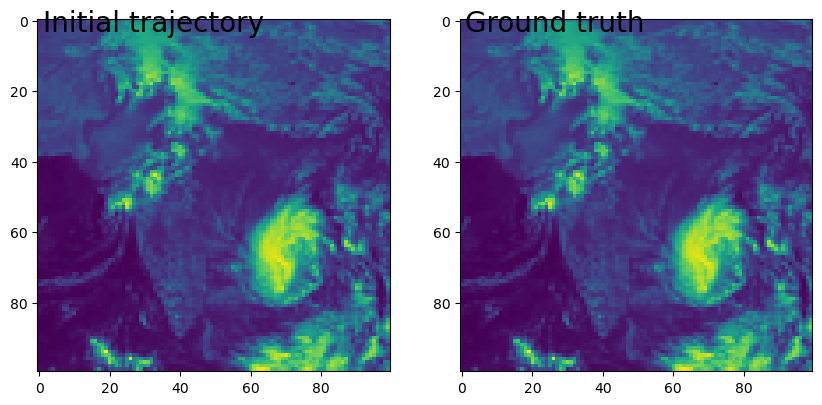

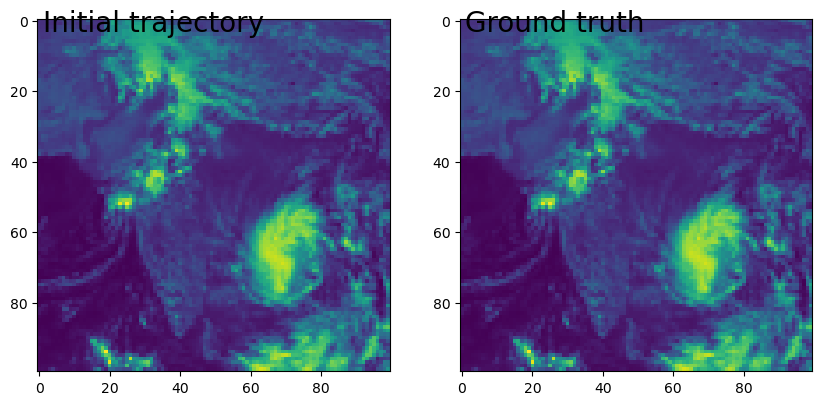

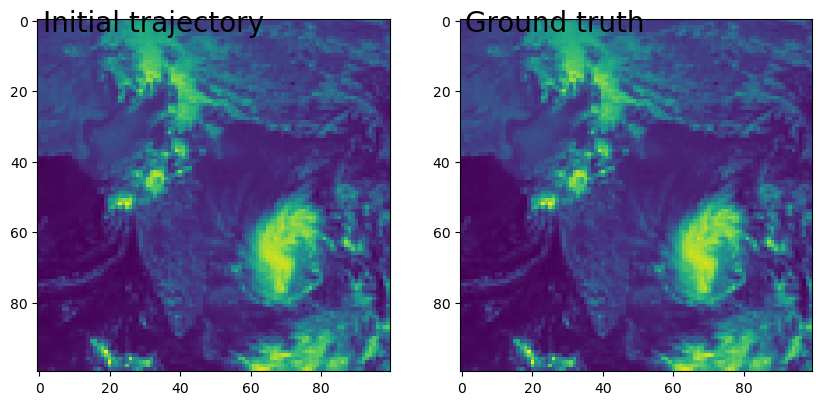

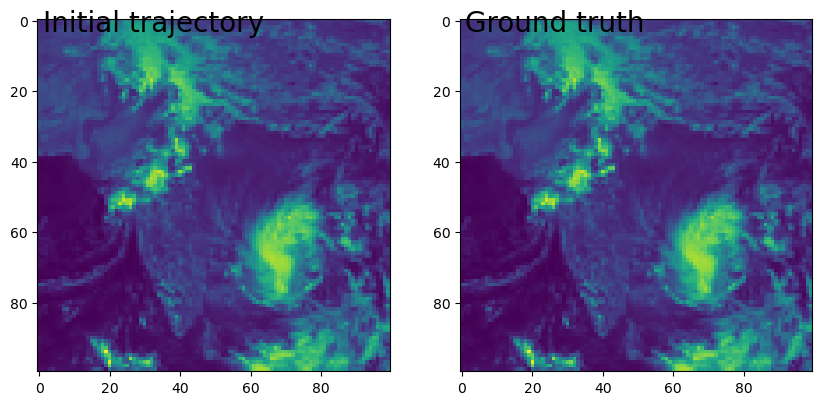

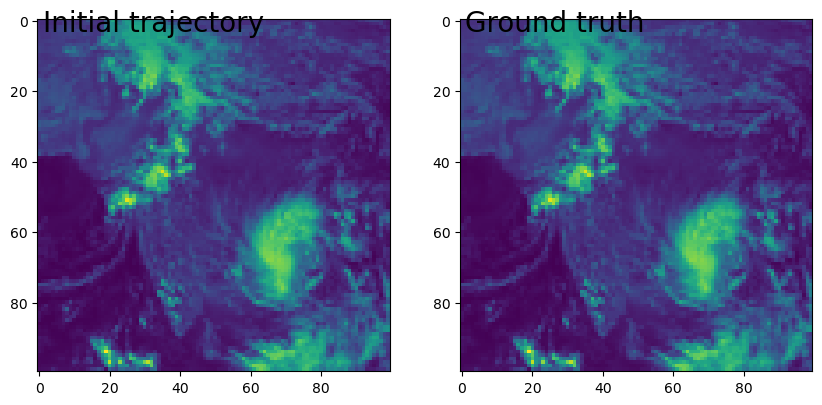

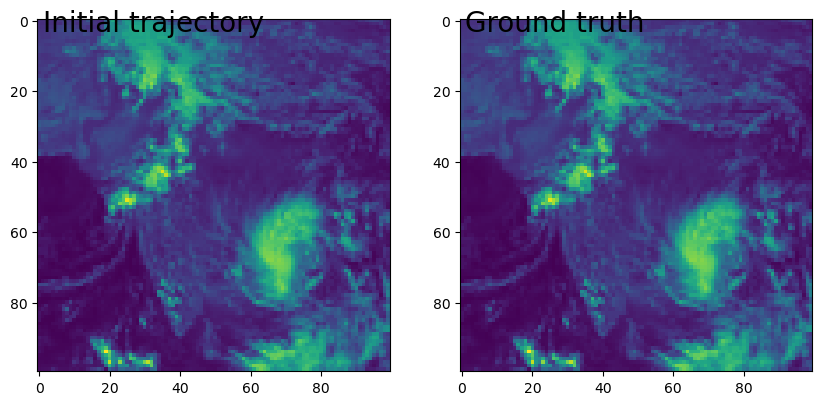

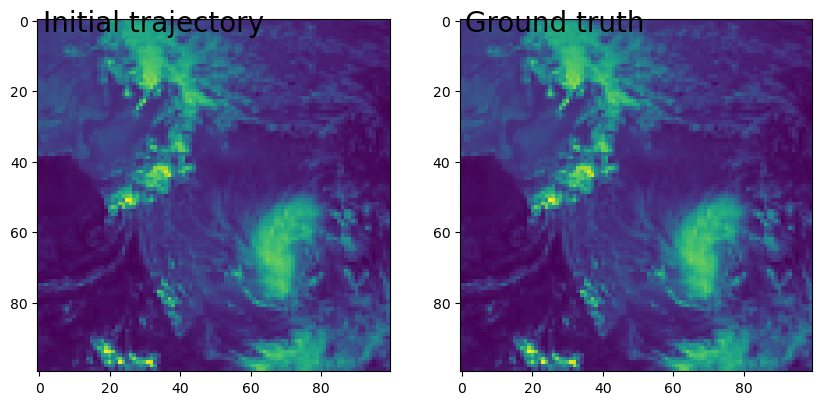

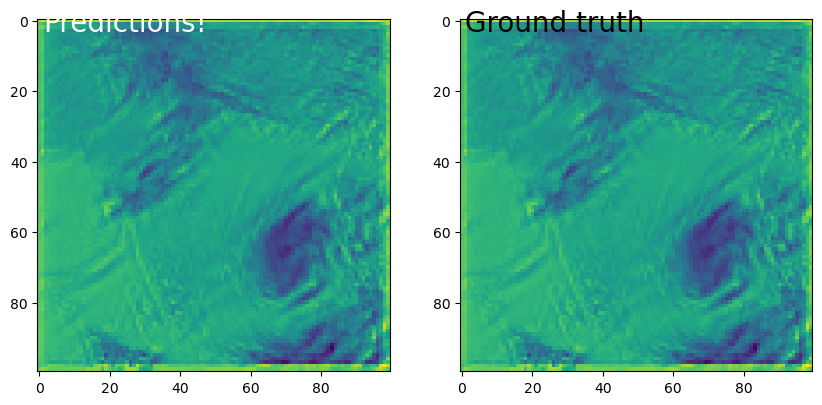

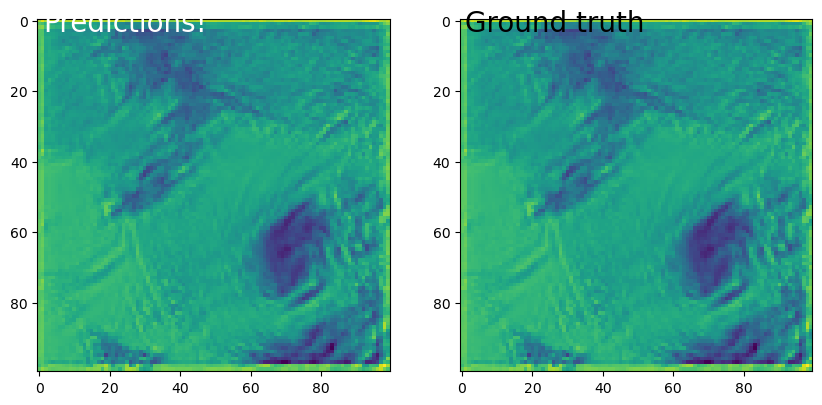

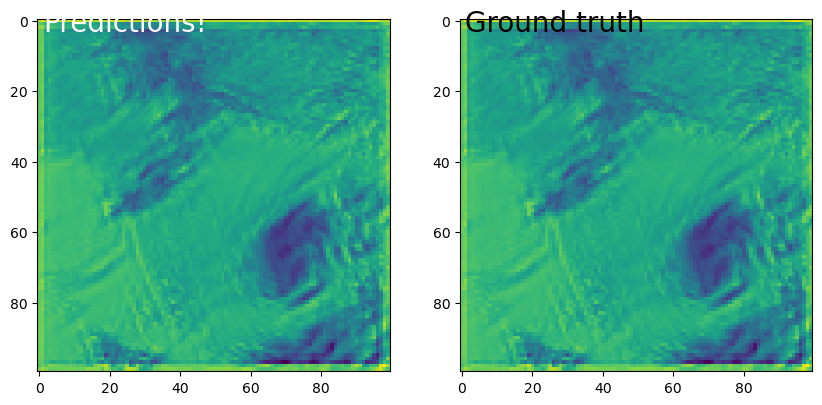

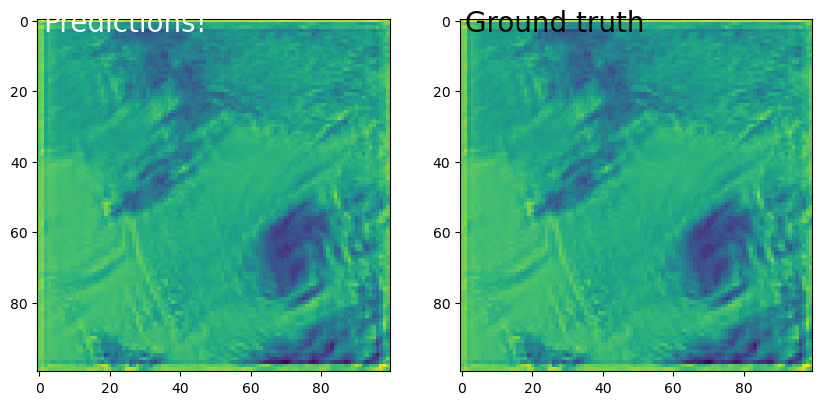

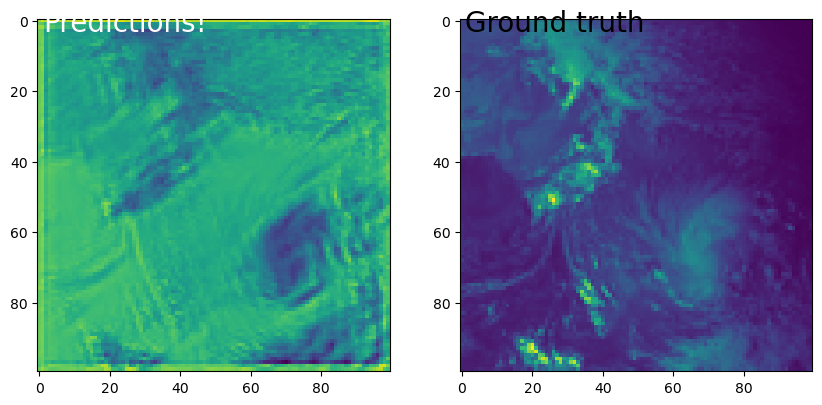

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv3D, MaxPooling3D
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def drawImage(img, title="image"):
    imarray = np.array(img)
    plt.title(title + str(imarray.shape))
    plt.imshow(img)
    plt.show()

# Define the path to your dataset
dirname = './DataSet/'
timeaccord = []
for fname in os.listdir(dirname):
    timeaccord.append(fname)
timeaccord.sort()

final = []
for fname in timeaccord[:24]:
    img = Image.open(os.path.join(dirname, fname))
    img = img.resize((100, 100))
    drawImage(img, fname)
    imarray = np.array(img)
    final.append(imarray)

final = np.array(final)
final = final / 255.0
print(final.shape)

x_train = []
y_train = []
for i in range(10, final.shape[0]):
    x_train.append(final[i-10:i])
for i in range(10, final.shape[0]):
    y_train.append(final[i-9:i+1])

X_train = np.array(x_train)
Y_train = np.array(y_train)
print(X_train.shape)
print(Y_train.shape)

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(None, 100, 100, 1), padding='same', return_sequences=True))
seq.add(Dropout(0.1))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
seq.add(Dropout(0.1))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
seq.add(Dropout(0.1))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
seq.add(Dropout(0.1))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
seq.add(Dropout(0.1))

seq.summary()

seq.compile(loss='binary_crossentropy', optimizer='adadelta')

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_loss', patience=2)
hist = seq.fit(X_train.reshape((14, 10, 100, 100, 1)), Y_train.reshape((14, 10, 100, 100, 1)), batch_size=10,
               epochs=32, validation_split=0.2, callbacks=[checkpoint, early])

# Plotting the loss
plt.figure(0)
plt.title("LOSS")
plt.plot(hist.history['loss'], 'g', label='Training loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation loss')
plt.legend()
plt.show()

X_train = X_train.reshape((14, 10, 100, 100, 1))
which = 12
track = X_train[which][:10, :, :, :]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, :, :, :, :])
    new = new_pos[:, -1, :, :, :]
    track = np.concatenate((track, new), axis=0)

# Compare predictions to ground truth
track2 = X_train[which][:, :, :, :]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)
    if i >= 10:
        ax.text(1, 3, 'Predictions!', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, :, :, 0]
    plt.imshow(toplot)

    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

img = Image.open(os.path.join(dirname, timeaccord[25]))
img = img.resize((100, 100))
plt.imshow(np.array(img)/9)
